In [1]:
!pip install sklearn
!pip install -U efficientnet
!pip install image-classifiers

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
#################################################################
# 0. Libraries

import datetime
import pandas as pd
import numpy as np
import os
import glob

from tqdm import tqdm

import tensorflow as tf
import matplotlib.pyplot as plt

import albumentations
from albumentations.core.transforms_interface import ImageOnlyTransform
import cv2
from functools import partial

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
# try:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)
# except:
#     print('Invalid device or cannot modify virtual devices once initialized.')

import efficientnet.tfkeras as efn
#from classification_models.tfkeras import Classifiers

from tensorflow.keras import models, layers, regularizers, metrics, losses, optimizers, constraints
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import Sequence

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score

np.random.seed(12)
from jarviscloud import jarviscloud

#################################################################

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
#################################################################
# 1. Global Variables & Paths

PATH = 'data/'
PATH_MODELS = '../02_Models/'

if not os.path.exists(PATH_MODELS):
    os.mkdir(PATH_MODELS)

# df_labels = pd.concat([
#     pd.read_csv(PATH + 'train_labels.csv'),
#     pd.read_csv(PATH + 'old_leaky_data/train_labels_old.csv'),
#     pd.read_csv(PATH + 'old_leaky_data/test_labels_old.csv'),
# ]).reset_index(drop=True)

df_labels = pd.read_csv(PATH + 'train_labels.csv')

df_sample_sub = pd.read_csv(PATH + 'sample_submission.csv')
print(df_labels['target'].value_counts()/len(df_labels))

list_paths_train = glob.glob(PATH + 'train/' + '*/*.npy') + glob.glob(PATH + 'old_leaky_data/train_old/' + '*/*.npy') + glob.glob(PATH + 'old_leaky_data/test_old/' + '*/*.npy')
list_paths_test = glob.glob(PATH + 'test/' + '*/*.npy')

print(f'{len(list_paths_train)} train paths, {len(list_paths_test)} test paths')

dict_paths_train = {path.split('/')[-1].split('.npy')[0] : path for path in list_paths_train}
dict_paths_test = {path.split('/')[-1].split('.npy')[0] : path for path in list_paths_test}

df_labels['path'] = df_labels['id'].apply(lambda x : dict_paths_train[x])
df_sample_sub['path'] = df_sample_sub['id'].apply(lambda x : dict_paths_test[x])

list_records = df_labels[['id', 'target']].to_dict('records')
dict_paths_labels_train = {elem['id'] : elem['target'] for elem in list_records}

# IMG_SIZE = (279*3, 256*3, 3)
# IMG_SIZE = (532, 532, 3)
IMG_SIZE = (819, 513, 3)
# IMG_SIZE_CROP = (512, 512, 3)

pos, neg = len(df_labels[df_labels['target']==1]), len(df_labels[df_labels['target']==0])

assert df_sample_sub.isna().sum().sum() == 0
assert df_labels.isna().sum().sum() == 0

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
df_labels["fold"] = -1
for fold_id, (_, val_idx) in enumerate(skf.split(df_labels["id"], df_labels["target"])):
    df_labels.loc[val_idx, "fold"] = fold_id

#################################################################

0    0.9
1    0.1
Name: target, dtype: float64
146012 train paths, 39995 test paths


In [4]:
#################################################################
# 2. Functions

def plotCadence(file_id):
    label = df_labels['target'][df_labels['id']==os.path.basename(file_id).split('.')[0]].values[0]
    img = np.load(file_id).astype(np.float32)
    plt.figure(figsize=(16, 10))
    for i in range(6):
        plt.subplot(6, 1, i + 1)
        if i == 0:
            plt.title(f"ID: {os.path.basename(file_id)} TARGET: {label}", fontsize=18)
        plt.imshow(img[i], interpolation='nearest', aspect='auto')
        plt.text(5, 100, ["ON", "OFF"][i % 2], bbox={'facecolor': 'white'})
    plt.show()
    
# '../01_Data/train\\b\\bd31565fc0f0.npy'
#################################################################

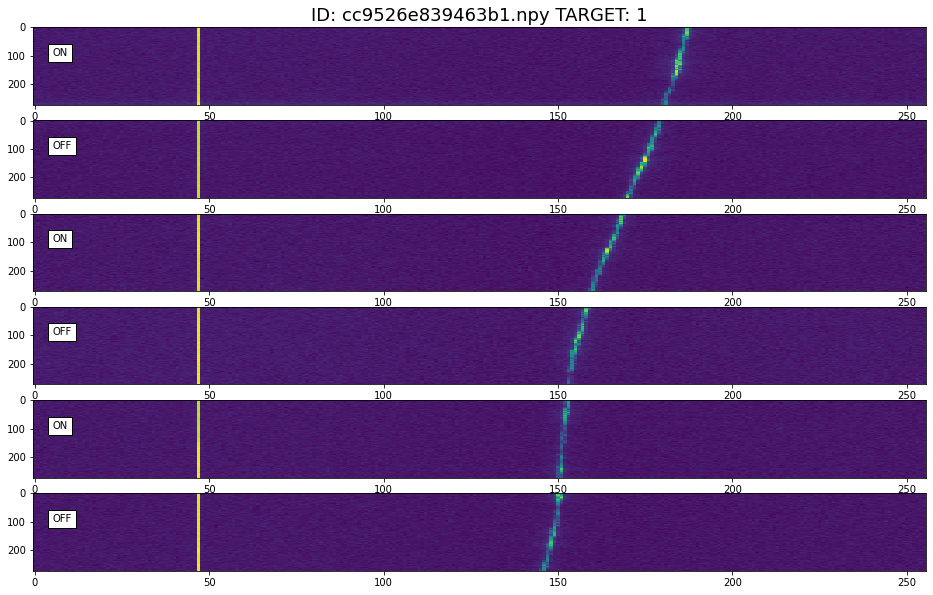

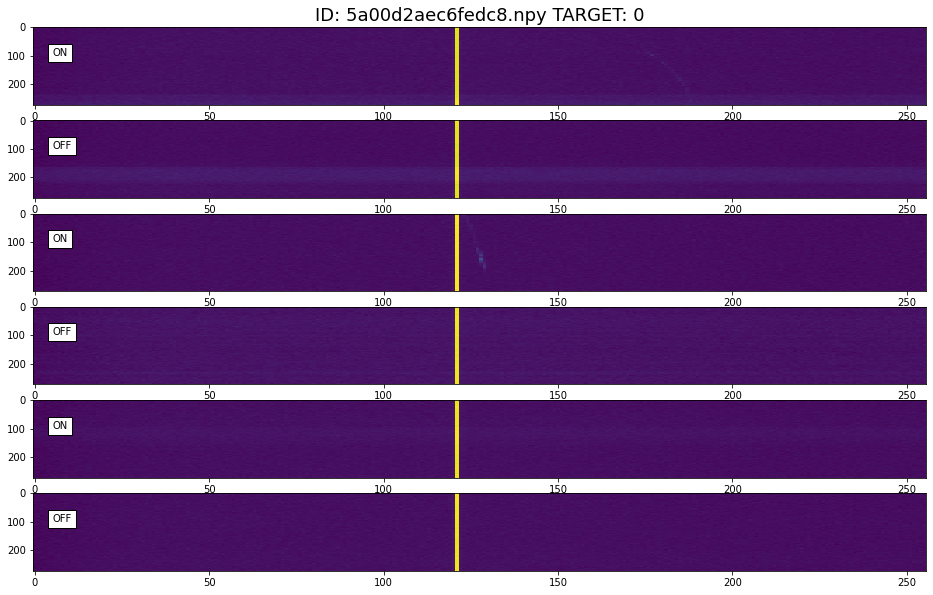

In [5]:
# idx = np.random.choice(list_paths_train)
idx = dict_paths_train['cc9526e839463b1']
plotCadence(idx)

idx = dict_paths_train['5a00d2aec6fedc8']
plotCadence(idx)

In [10]:
#################################################################
# 3. Data Loader

def buildLoader(labels=True):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        img = tf.io.decode_raw(file_bytes, tf.float16)
        img = tf.reshape(img[64:], [6, 273, 256]) # 419328 = 6 * 273 * 256
        img = tf.cast(img, tf.float32)
        return img
    
    def decodeWithLabels(path, label):
        img = decode(path)
        return img, label
    
    if labels:
        return decodeWithLabels
    else:
        return decode
    
    
def normalizeImage(data, label):
    list_img_norm = []
    for i in range(6):
        img = data[i]
        img -= tf.reduce_mean(img)
        img /= tf.math.reduce_std(img)
        list_img_norm.append(img)
    img_norm = tf.cast(tf.stack(list_img_norm, axis=0), tf.float32)
    return img_norm, label
    
    
# def preprocessImage(img, label):
#     img_on = tf.concat([img[0], img[2], img[4]], axis=0)
#     img_off = tf.concat([img[1], img[3], img[5]], axis=0)
#     img_diff = tf.abs(img_on - img_off)
#     img = tf.stack([img_on, img_off, img_diff], -1)
#     img = tf.image.resize(img, size=[IMG_SIZE[0], IMG_SIZE[1]])
#     img = tf.image.random_crop(img, size=IMG_SIZE_CROP)
#     img = tf.cast(img, tf.float32)
#     return img, label


def preprocessImage(img, label):
    img = tf.expand_dims(img, -1)
    img = tf.concat([img[0], img[1], img[2], img[3], img[4], img[5]], 0)
    img = tf.image.resize(img, size=[IMG_SIZE[0], IMG_SIZE[1]])
    img = tf.concat([img, img, img], -1)
    img = tf.cast(img, tf.float32)
    label = tf.cast(label, tf.float32)
    return img, label


def set_shapes(img, label):
    img.set_shape(IMG_SIZE)
    if label is not None:
        label.set_shape([])
    return img, label


# def buildAugmentations():
#     def applyAugmentations(image, label):
#         image = tf.image.random_flip_left_right(image)
#         image = tf.image.random_flip_up_down(image)
#         image = tf.add(image, tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.075, dtype=tf.float32))
#         return image, label
#     return applyAugmentations


def buildAugmentations(run=None):
    if run is None:
        def applyAugmentations(image, label):
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_flip_up_down(image)
            image = tf.add(image, tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.075, dtype=tf.float32))
            return image, label
        return applyAugmentations
    else:
        if run == 0:
            def applyAugmentations(image, label):
                return image, label
        elif run == 1:
            def applyAugmentations(image, label):
                image = tf.image.flip_left_right(image)
                return image, label
        elif run == 2:
            def applyAugmentations(image, label):
                image = tf.image.flip_up_down(image)
                return image, label
        elif run == 3:
            def applyAugmentations(image, label):
                image = tf.image.flip_left_right(image)
                image = tf.image.flip_up_down(image)
                return image, label
        else:
            def applyAugmentations(image, label):
                # image = tf.image.random_flip_left_right(image)
                # image = tf.image.random_flip_up_down(image)
                # image = tf.add(image, tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.075, dtype=tf.float32))
                return image, label
    return applyAugmentations


def build_dataset(paths, labels=None, bsize=32, shuffle=True, augmentations=True, p_mixup=0.3, run=None):
    aug_builder = buildAugmentations(run) if run is not None else buildAugmentations()
    loader = buildLoader(False if labels is None else True) 
    AUTO = tf.data.AUTOTUNE
    slices = (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    if shuffle:
        dset = dset.shuffle(len(labels))
        
    dset = dset.map(loader, num_parallel_calls=AUTO).prefetch(AUTO)
    dset = dset.map(normalizeImage, num_parallel_calls=AUTO)
    dset = dset.map(preprocessImage, num_parallel_calls=AUTO)
    if augmentations:
        dset = dset.map(aug_builder, num_parallel_calls=AUTO)
    dset = dset.map(set_shapes, num_parallel_calls=AUTO)
    if p_mixup>0.0:
        dset = dset.batch(bsize, drop_remainder=True).prefetch(AUTO)
        dset = dset.map(mixup_builder, num_parallel_calls=AUTO)
    else:
        dset = dset.batch(bsize, drop_remainder=False).prefetch(AUTO)
    return dset   
            

#################################################################

In [7]:
# train_data_generator = build_dataset(list_paths_train, labels=[dict_paths_labels_train[x] for x in dict_paths_labels_train], bsize=32, shuffle=True, p_mixup=0.0)
# for batch in tqdm(train_data_generator):
#     pass

# v0 -   1%|▉                                                                               | 51/4562 [00:07<10:22,  7.25it/s]
# v1 - augmentations tf - 1%|█▏                                                                              | 67/4562 [00:08<09:16,  8.08it/s]
# v1 - augmentations tf - 1%|█▏                                                                              | 67/4562 [00:08<08:07,  9.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


(64, 819, 513, 3) (64,)
tf.Tensor(1.0, shape=(), dtype=float32)


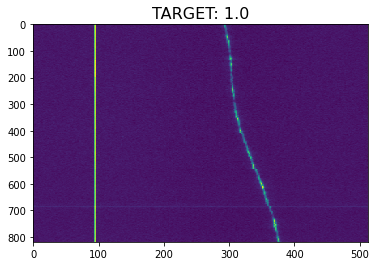

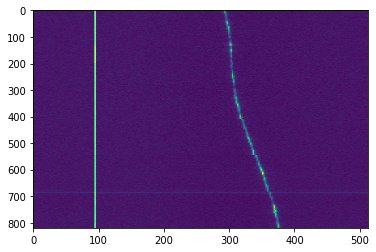

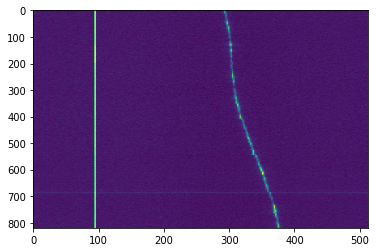

(64, 819, 513, 3) (64,)
tf.Tensor(0.0, shape=(), dtype=float32)


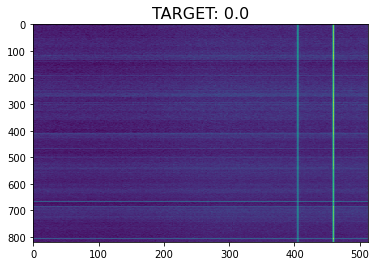

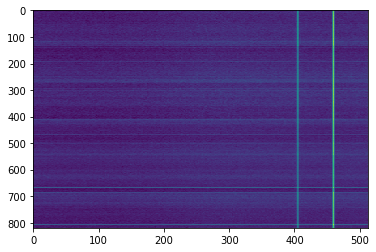

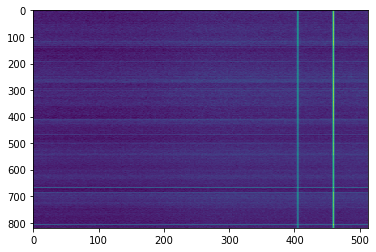

(64, 819, 513, 3) (64,)
tf.Tensor(0.0, shape=(), dtype=float32)


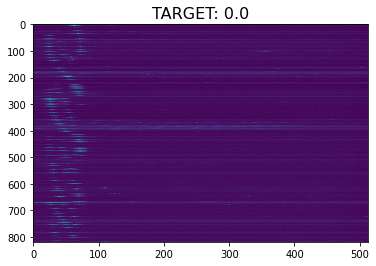

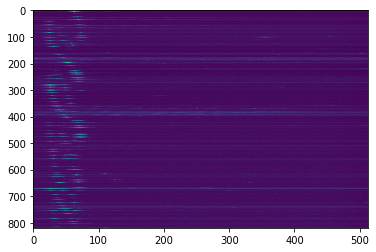

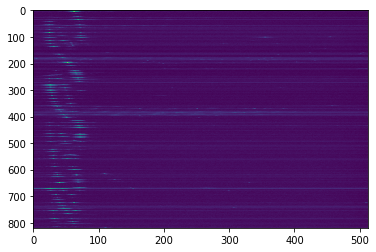

In [8]:
list_paths = [dict_paths_train['cc9526e839463b1']] + list(dict_paths_train.values())[:63]
list_labels = [dict_paths_labels_train[x.split('/')[-1].split('.npy')[0]] for x in list_paths]
dataset_train = build_dataset(list_paths, labels=list_labels, bsize=64, shuffle=False, p_mixup=0.0)
for batch in tqdm(dataset_train):
    data, target = batch
    # print(np.mean(target))
    break

data, target = batch

idx = 0
print(data.shape, target.shape)
print(target[idx])
plt.title(f"TARGET: {target[idx].numpy()}", fontsize=16)
plt.imshow(data[idx, :, :, 0], interpolation='nearest', aspect='auto');plt.show();
plt.imshow(data[idx, :, :, 1], interpolation='nearest', aspect='auto');plt.show();
plt.imshow(data[idx, :, :, 2], interpolation='nearest', aspect='auto');plt.show();

idx = -3
print(data.shape, target.shape)
print(target[idx])
plt.title(f"TARGET: {target[idx].numpy()}", fontsize=16)
plt.imshow(data[idx, :, :, 0], interpolation='nearest', aspect='auto');plt.show();
plt.imshow(data[idx, :, :, 1], interpolation='nearest', aspect='auto');plt.show();
plt.imshow(data[idx, :, :, 2], interpolation='nearest', aspect='auto');plt.show();

idx = 28
print(data.shape, target.shape)
print(target[idx])
plt.title(f"TARGET: {target[idx].numpy()}", fontsize=16)
plt.imshow(data[idx, :, :, 0], interpolation='nearest', aspect='auto');plt.show();
plt.imshow(data[idx, :, :, 1], interpolation='nearest', aspect='auto');plt.show();
plt.imshow(data[idx, :, :, 2], interpolation='nearest', aspect='auto');plt.show();


In [9]:
# img_on = np.vstack(np.load(list_paths[20])[::2]).astype(np.float32)
# img_off = np.vstack(np.load(list_paths[20])[[1, 3, 5]]).astype(np.float32)
# img_diff = np.abs(img_on - img_off)
# print(img_on.shape, img_off.shape)
# plt.imshow(img_on, interpolation='nearest', aspect='auto')
# plt.show();
# plt.imshow(img_off, interpolation='nearest', aspect='auto')
# plt.show();
# plt.imshow(img_diff, interpolation='nearest', aspect='auto')
# plt.show();

In [7]:
#################################################################
# 4. Model

class BaseEncoderImgs(models.Model):
    def __init__(self):
        super(BaseEncoderImgs, self).__init__()
#         self.backbone_model = efn.EfficientNetB4(input_shape=(IMG_SIZE_CROP[0], IMG_SIZE_CROP[1], 3),
#                                                                 include_top=False, weights='imagenet')
        self.backbone_model = efn.EfficientNetB2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                                                                include_top=False, weights='imagenet')
#         ResNet34, preprocess_input = Classifiers.get('resnet34')
#         self.backbone_model = tf.keras.applications.InceptionV3(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
#                                                                  include_top=False, weights='imagenet')
#         self.backbone_model = ResNet34(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
#                                        include_top=False, weights='imagenet')
        self.backbone_model.trainable = True
        
    def call(self, img_input, training):
        x = self.backbone_model(img_input, training)
        return x
    
    
class Model(models.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.img_encoder = BaseEncoderImgs()
        ###
        self.avg_glob_pool = layers.GlobalAveragePooling2D()
        self.fc_final = models.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.3)
        ])
        self.final_layer = layers.Dense(1, activation='sigmoid')
    
    def call(self, inputs, training=True):
        x = self.img_encoder(inputs, training=training)
        x = self.avg_glob_pool(x)
        x = self.fc_final(x, training)
        prob = self.final_layer(x)
        return prob
    
def getModel():
    return Model()


class ReturnBestEarlyStopping(tf.keras.callbacks.EarlyStopping):
    def __init__(self, **kwargs):
        super(ReturnBestEarlyStopping, self).__init__(**kwargs)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            if self.verbose > 0:
                print(f'\nEpoch {self.stopped_epoch + 1}: early stopping')
        elif self.restore_best_weights:
            if self.verbose > 0:
                print('Restoring model weights from the end of the best epoch.')
            self.model.set_weights(self.best_weights)
            
            
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.cast(tf.math.minimum(arg1, arg2), tf.float32)

#################################################################

Text(0.5, 0, 'Train Step')

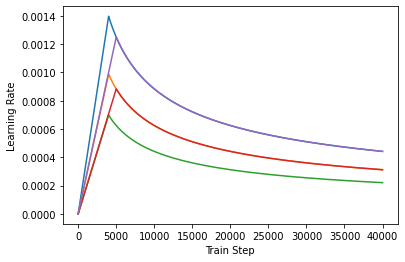

In [11]:
temp_learning_rate_schedule = CustomSchedule(128)

plt.plot(temp_learning_rate_schedule(tf.range(40_000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

temp_learning_rate_schedule = CustomSchedule(256)

plt.plot(temp_learning_rate_schedule(tf.range(40_000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

temp_learning_rate_schedule = CustomSchedule(512)

plt.plot(temp_learning_rate_schedule(tf.range(40_000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

temp_learning_rate_schedule = CustomSchedule(256, 5_000)

plt.plot(temp_learning_rate_schedule(tf.range(40_000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

temp_learning_rate_schedule = CustomSchedule(128, 5_000)

plt.plot(temp_learning_rate_schedule(tf.range(40_000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [12]:
#################################################################
# 5. Training

tf.keras.backend.clear_session()
# tf.config.optimizer.set_jit(True)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

batch_size = 40
epochs = 28
model_base_name = 'model_v0.12'
load_model = (False, model_base_name, 0.21)
early_stop = ReturnBestEarlyStopping(monitor='val_loss', mode="min", patience=6, verbose=1, restore_best_weights=True)


for fold in range(1):
    print('==='*30)
    print(f'Fold: {fold}')
    print('==='*30)
    
    list_imgs_t = list(df_labels['id'][df_labels['fold']!=fold].values)
    list_imgs_val = list(df_labels['id'][df_labels['fold']==fold].values)
    
    print(f'Train images: {len(list_imgs_t)}, Val images: {len(list_imgs_val)}')
    
    list_paths_t, list_labels_t = [dict_paths_train[x] for x in list_imgs_t],  [dict_paths_labels_train[x] for x in list_imgs_t]
    list_paths_val, list_labels_val = [dict_paths_train[x] for x in list_imgs_val],  [dict_paths_labels_train[x] for x in list_imgs_val]
    
    train_data_generator = build_dataset(list_paths_t, labels=list_labels_t, bsize=batch_size, augmentations=True, shuffle=True, p_mixup=0.0)
    val_data_generator = build_dataset(list_paths_val, labels=list_labels_val, bsize=batch_size, augmentations=False, shuffle=False, p_mixup=0.0)

    # Model
    if load_model[0]:
        print(f'Tranining new model loading ckpt from {load_model[1]} ...')
        model = models.load_model(f'{PATH_MODELS + load_model[1]}/{load_model[1]}_fold_{fold}')
    else:
        print(f'Tranining full new model ...')
        model = getModel()
        
    learning_rate = CustomSchedule(128)
    model.compile(optimizer=mixed_precision.LossScaleOptimizer(optimizers.Adam(learning_rate)),
                  loss=losses.BinaryCrossentropy(),
                  metrics=[metrics.BinaryAccuracy(name='acc'), metrics.AUC(name='auc'),
                           metrics.Precision(name='precission'), metrics.Recall(name='recall'), metrics.AUC(name='prc', curve='PR')])

    history = model.fit(train_data_generator,
                        validation_data=val_data_generator,
                        batch_size=batch_size,
                        callbacks=[early_stop],
                        epochs=epochs,
                        verbose=1)
    
    if not os.path.exists(PATH_MODELS + model_base_name):
        os.mkdir(PATH_MODELS + model_base_name)
        
    model.save(f'{PATH_MODELS + model_base_name}/{model_base_name}_fold_{fold}', include_optimizer=False)
    model.save_weights(f'{PATH_MODELS + model_base_name}/{model_base_name}_fold_{fold}_weights', save_format='tf')

#################################################################

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100-PCIE-40GB, compute capability 8.0
Fold: 0
Train images: 48000, Val images: 12000
Tranining full new model ...
Epoch 1/28
1200/1200 [==============================] - 496s 380ms/step - loss: 0.3158 - acc: 0.9056 - auc: 0.6456 - precission: 0.6031 - recall: 0.1627 - prc: 0.2974 - val_loss: 0.2463 - val_acc: 0.9282 - val_auc: 0.7615 - val_precission: 0.9856 - val_recall: 0.2858 - val_prc: 0.5238
Epoch 2/28
1200/1200 [==============================] - 450s 375ms/step - loss: 0.2277 - acc: 0.9365 - auc: 0.7784 - precission: 0.8994 - recall: 0.4115 - prc: 0.5769 - val_loss: 0.2169 - val_acc: 0.9402 - val_auc: 0.8107 - val_precission: 0.9184 - val_recall: 0.4408 - val_prc: 0.6148
Epoch 3/28
1200/1200 [==============================] - 448s 373ms/step - loss: 0.2209 - acc: 0.9384 - auc: 0.789

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ../02_Models/model_v0.12/model_v0.12_fold_0/assets


In [13]:
# ==========================================================================================
# Fold: 0
# ==========================================================================================
# Train images: 48000, Val images: 12000
# Tranining full new model ...
# Epoch 1/25
#  474/1500 [========>.....................] - ETA: 5:31 - loss: 0.3491 - acc: 0.8973 - auc: 0.5226 - precission: 0.0519 - recall: 0.0027 - prc: 0.1029

In [ ]:
#################################################################
# 6. Validation

def auc_group(df):
    y_pred = df.preds
    y_true = df.target
    return roc_auc_score(y_true, np.where(y_pred>0.5, 1, 0))

batch_size = 32

df_val_preds = pd.DataFrame()
for fold in range(5):
    print('==='*30)
    print(f'Fold: {fold}')
    print('==='*30)
    
    list_imgs_val = list(df_labels['id'][df_labels['fold']==fold].values)

    list_paths_val, list_labels_val = [dict_paths_train[x] for x in list_imgs_val],  [dict_paths_labels_train[x] for x in list_imgs_val]
    val_data_generator = build_dataset(list_paths_val, labels=list_labels_val, bsize=batch_size, augmentations=False, shuffle=False, p_mixup=0.0)
    
    model = models.load_model(PATH_MODELS + model_base_name + '/' + model_base_name + f'_fold_{fold}')
    preds = model.predict(val_data_generator, verbose=1)
    
    df_tmp = pd.DataFrame({
        'id' : list_imgs_val,
        'fold' : fold,
        'preds' : preds.squeeze(-1) 
    })
    
    df_tmp = pd.merge(df_tmp, df_labels[['id', 'target']], how='inner', on='id')
    df_val_preds = pd.concat([df_val_preds, df_tmp], axis=0).reset_index(drop=True)
          
auc = roc_auc_score(df_val_preds['target'].values, df_val_preds['preds'].values)        
precision = precision_score(df_val_preds['target'].values, np.where(df_val_preds['preds'].values>0.5, 1, 0))
recall = recall_score(df_val_preds['target'].values,  np.where(df_val_preds['preds'].values>0.5, 1, 0))
print(f'AUC: {np.round(auc, 4)}, Precission: {np.round(precision, 4)}, Recall: {np.round(recall, 4)}')
print(df_val_preds.groupby('fold').apply(auc_group))
df_val_preds.to_csv(f'./df_oof_{model_base_name}.csv', index=False)

# (new data) - (lb: 0.711) - model v0.6.1  AUC: 0.8094, Precission: 0.9409, Recall: 0.4163
# 0    0.686111
# 1    0.688380
# 2    0.720278
# 3    0.725741
# 4    0.713056

# (new data) - (lb: 0.719) - model v0.7  AUC: 0.814, Precission: 0.9311, Recall: 0.4573
# 0    0.722176
# 1    0.745741
# 2    0.704537
# 3    0.734120
# 4    0.727361

# (new data) - (lb: 0.722) - model v0.7.1  AUC: 0.815, Precission: 0.9535, Recall: 0.451
# 0    0.725046
# 1    0.705046
# 2    0.731065
# 3    0.734120
# 4    0.727361

# (new data) - (lb: 0.725) - model v0.7.1  AUC: 0.818, Precission: 0.9618, Recall: 0.4493
# 0    0.725046
# 1    0.705046
# 2    0.731065
# 3    0.729861
# 4    0.727361

# (new data) - (lb: 0.748) - model v0.8 AUC: 0.8466, Precission: 0.9455, Recall: 0.5208
# 0    0.725046
# 1    0.705046
# 2    0.731065
# 3    0.729861
# 4    0.727361

# (new data) - (lb: 0.752) - model v0.9 AUC: 0.8496, Precission: 0.9617, Recall: 0.5235
# 0    0.753611
# 1    0.776250
# 2    0.755463
# 3    0.758750
# 4    0.758889

# (new data) - (lb: 0.) - model v0.10 AUC: 0.8637, Precission: 0.9644, Recall: 0.5648
# 0    0.776389
# 1    0.782407
# 2    0.773287
# 3    0.788843
# 4    0.785370


#################################################################

Fold: 0
375/375 [==============================] - 34s 78ms/step
Fold: 1


In [ ]:
#################################################################
# 7. Submission

submission_name = f'{model_base_name}_{datetime.date.today().strftime("%d_%m_%Y")}'

list_models = [models.load_model(PATH_MODELS + model_base_name + '/' + model_base_name + f'_fold_{fold}') for fold in range(5)]

list_paths_test = list(dict_paths_test.values())
test_data_generator = build_dataset(list_paths_test, labels=list(np.zeros(len(list_paths_test))), bsize=batch_size, augmentations=False, shuffle=False, p_mixup=0.0)

list_preds = []
for batch in tqdm(test_data_generator):
    preds = np.mean([model(batch[0], training=False) for model in list_models], axis=0)
    list_preds.append(preds.squeeze(-1))

df_submission =pd.DataFrame({
    'id' : list(dict_paths_test),
    'target' : np.concatenate(list_preds)
})

df_submission.to_csv(f'./{submission_name}.csv', index=False)
df_submission.describe()

#################################################################

100%|██████████| 1250/1250 [05:09<00:00,  4.03it/s]


,target
count,39995.000000
mean,0.225830
std,0.367188
min,0.001076
25%,0.025024
50%,0.037445
75%,0.115967
max,1.000000


In [11]:
#################################################################
# 8. Submission + TTA

model_base_name = 'model_v0.12'
num_reps = 4
batch_size = 16
submission_name = f'{model_base_name}_{datetime.date.today().strftime("%d_%m_%Y")}'
submission_name = f'{submission_name}_tta'

list_models = [models.load_model(PATH_MODELS + model_base_name + '/' + model_base_name + f'_fold_{fold}') for fold in range(1)]

list_paths_test = list(dict_paths_test.values())

list_final_preds = []
for nrep in range(num_reps):
    list_preds = []
    test_data_generator = build_dataset(list_paths_test, labels=list(np.zeros(len(list_paths_test))), bsize=batch_size, augmentations=True, shuffle=False, p_mixup=0.0, run=nrep)
    for batch in tqdm(test_data_generator):
        preds = np.mean([model(batch[0], training=False) for model in list_models], axis=0)
        list_preds.extend(preds.squeeze(-1))
    list_final_preds.append(list_preds)

df_submission =pd.DataFrame({
    'id' : list(dict_paths_test),
    'target' : np.mean(list_final_preds, 0)
})

df_submission.to_csv(f'./{submission_name}.csv', index=False)
df_submission.describe()

#################################################################

100%|██████████| 2500/2500 [02:18<00:00, 18.02it/s]


,target
count,39995.000000
mean,0.249146
std,0.352539
min,0.000015
25%,0.042603
50%,0.079651
75%,0.186768
max,1.000000


In [ ]:
jarviscloud.pause()